# Looking Through The Data

In [1]:
pip install -q transformers datasets nltk pandas numpy matplotlib py7zr evaluate sacrebleu rouge_score


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
dataset= load_dataset("samsum")
print(dataset)

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [3]:
import       c
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

string ="The U.S. is a country. while The U.N. is an organization."
print(sent_tokenize(string))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['The U.S. is a country.', 'while The U.N. is an organization.']


In [4]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

In [5]:
summaries ={}
sample_text=dataset["train"][0]["dialogue"]
summaries['baseline']=three_sentence_summary(sample_text)

In [6]:
from transformers import pipeline
pipe= pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out=pipe(sample_text)
print(pipe_out)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 142, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


[{'summary_text': 'Amanda: I baked  cookies. Do you want some? Jerry: Sure. Amanda: I\'ll bring them tomorrow :-) Jerry: "Sure!" Amanda: "I\'ll bring you tomorrow :-) " Jerry:  "Sure! I\'ll get them for you tomorrow!"'}]


In [7]:
summaries['bart']="\n".join(sent_tokenize(pipe_out[0]['summary_text']))

## Comparing different summaries

In [8]:
print("Ground Truth Summary")
print(dataset["test"][1]["summary"])
print("")
print("")

print("Baseline Summary")
print(summaries['baseline'])

print("")
print("")

print("Bart Summary")
print(summaries['bart'])

Ground Truth Summary
Eric and Rob are going to watch a stand-up on youtube.


Baseline Summary
Amanda: I baked  cookies.
Do you want some?
Jerry: Sure!


Bart Summary
Amanda: I baked  cookies.
Do you want some?
Jerry: Sure.
Amanda: I'll bring them tomorrow :-) Jerry: "Sure!"
Amanda: "I'll bring you tomorrow :-) " Jerry:  "Sure!
I'll get them for you tomorrow!"


# Measuring Quality with metrics

In [5]:
from evaluate import load
bleu_metric = load("sacrebleu")
rouge_metric = load("rouge")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction=summaries['baseline'], reference=dataset['test'][0]['summary'])
bleu_score = bleu_metric.compute(smooth_method='floor', smooth_value=0)
pd.DataFrame.from_dict(bleu_score,orient="index", columns=['Values'])

,Values
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[15, 14, 13, 12]"
precisions,"[13.333333333333334, 0.0, 0.0, 0.0]"
bp,0.935507
sys_len,15
ref_len,16


In [11]:
bleu_metric.add(prediction=summaries['bart'], reference=dataset['test'][0]['summary'])
bleu_score = bleu_metric.compute(smooth_method='floor', smooth_value=0)
pd.DataFrame.from_dict(bleu_score,orient="index", columns=['Values'])

,Values
score,0.0
counts,"[3, 0, 0, 0]"
totals,"[54, 53, 52, 51]"
precisions,"[5.555555555555555, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,54
ref_len,16


In [12]:
rouge_metric.add(prediction=summaries['baseline'], reference=dataset['test'][0]['summary'])
rouge_score = rouge_metric.compute()
pd.DataFrame.from_dict(rouge_score,orient="index", columns=['Values'])

,Values
rouge1,0.076923
rouge2,0.000000
rougeL,0.076923
rougeLsum,0.076923


In [13]:
rouge_metric.add(prediction=summaries['bart'], reference=dataset['test'][0]['summary'])
rouge_score = rouge_metric.compute()
pd.DataFrame.from_dict(rouge_score,orient="index", columns=['Values'])

,Values
rouge1,0.040816
rouge2,0.000000
rougeL,0.040816
rougeLsum,0.040816


## Evaluate on the whole test data

In [6]:
#evaluate model on the whole test data for baseline and bart
def evaluate_summaries_baseline(dataset,metric,column_text='dialogue',column_summary="summary"):
  summaries=[three_sentence_summary(d) for d in dataset[column_text]]
  metric.add_batch(predictions=summaries, references=dataset[column_summary])
  score=metric.compute()
  return score

In [14]:
score=evaluate_summaries_baseline(dataset['test'],bleu_metric)
pd.DataFrame.from_dict(score,orient="index", columns=['Baseline'])

,Baseline
score,3.962639
counts,"[7006, 1864, 867, 423]"
totals,"[38572, 37753, 36934, 36115]"
precisions,"[18.16343461578347, 4.937355971710858, 2.34743..."
bp,1.0
sys_len,38572
ref_len,18482


In [15]:
score=evaluate_summaries_baseline(dataset['test'],rouge_metric)
pd.DataFrame.from_dict(score,orient="index", columns=['Baseline'])

,Baseline
rouge1,0.297439
rouge2,0.086390
rougeL,0.229036
rougeLsum,0.266983


In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_ckpt = "facebook/bart-large-cnn"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

cuda


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

## Understand the new lengths of the data to be trained on

<function matplotlib.pyplot.show(close=None, block=None)>

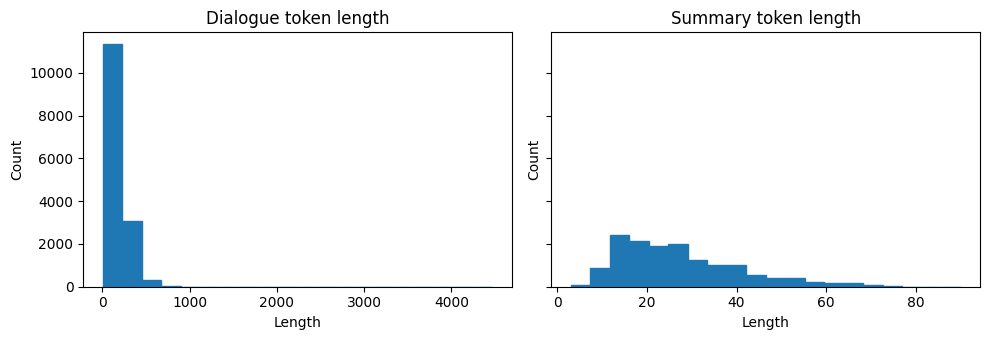

In [20]:
import matplotlib.pyplot as plt

d_len= [len(tokenizer.encode(s)) for s in dataset['train']['dialogue']]
s_len= [len(tokenizer.encode(s)) for s in dataset['train']['summary']]

fig,axes= plt.subplots(1,2, figsize=(10,3.5), sharey=True)
axes[0].hist(d_len,bins=20,color="C0",edgecolor="C0")
axes[0].set_title("Dialogue token length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary token length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show

In [9]:
from tqdm import tqdm

def chunks(list_of_elements, batch_size):
  for i in range(0,len(list_of_elements), batch_size):
    yield list_of_elements[i:i+batch_size]

def evaluate_summaries_bart(dataset,metric,model,tokenizer,batch_size=16,device=device,column_text='dialogue',column_summary="summary"):
  article_batches=list(chunks(dataset[column_text],batch_size))
  target_batches=list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(zip(article_batches,target_batches),total=len(article_batches)):
    inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
    summaries=model.generate(input_ids=inputs["input_ids"].to(device),
                             attention_mask=inputs["attention_mask"].to(device),
                             length_penalty=0.8,
                             num_beams=8,
                             max_length=128)
    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_space=True) for s in summaries]
    metric.add_batch(predictions=decoded_summaries, references=target_batch)

  score=metric.compute()
  return score

In [17]:
score=evaluate_summaries_bart(dataset['test'],bleu_metric,model,tokenizer,batch_size=8)
pd.DataFrame.from_dict(score,orient="index", columns=['BART'])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 103/103 [16:57<00:00,  9.88s/it]


,BART
score,4.976941
counts,"[8918, 2771, 1272, 631]"
totals,"[43641, 42822, 42003, 41184]"
precisions,"[20.434912123920167, 6.470972864415487, 3.0283..."
bp,1.0
sys_len,43641
ref_len,18482


In [22]:
score=evaluate_summaries_bart(dataset['test'],rouge_metric,model,tokenizer,batch_size=8)
pd.DataFrame.from_dict(score,orient="index", columns=['BART'])

100%|██████████| 103/103 [16:45<00:00,  9.77s/it]


,BART
rouge1,0.300296
rouge2,0.097910
rougeL,0.226476
rougeLsum,0.226552


# Finetuning for better results

In [10]:
def convert_examples_to_features(example_batch):
    input_encodings=tokenizer(example_batch['dialogue'],max_length=1024,truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encoding=tokenizer(example_batch['summary'],max_length=128, truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encoding["input_ids"]}
dataset_samsum=dataset.map(convert_examples_to_features, batched =True)
columns=["input_ids","attention_mask","labels"]
dataset_samsum.set_format(type="torch",columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [11]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model)

In [12]:
!huggingface-cli login --token #paste your token here

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [13]:
import wandb
wandb.login(key="your key")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
from transformers import TrainingArguments, Trainer

args= TrainingArguments(output_dir="bart-samsum-1-epoch",
                        num_train_epochs=1,
                        warmup_steps=500,
                        per_device_train_batch_size=1,
                        per_device_eval_batch_size=1,
                        weight_decay=0.01,
                        logging_steps=25,
                        push_to_hub=True,
                        eval_strategy="steps",
                        eval_steps=100,
                        gradient_accumulation_steps=16
                           )

In [14]:
trainer=Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum['train'],
    eval_dataset=dataset_samsum['validation'],
)

In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: pandahd75. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss,Validation Loss
100,1.388200,1.429308
200,1.335900,1.383932
300,1.349100,1.414781
400,1.317500,1.383670


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=460, training_loss=1.3953259115633758, metrics={'train_runtime': 3644.9809, 'train_samples_per_second': 4.042, 'train_steps_per_second': 0.126, 'total_flos': 6795714120007680.0, 'train_loss': 1.3953259115633758, 'epoch': 0.9991854466467553})

In [14]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_ckpt = "HuggingPanda/bart-samsum-1-epoch"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

cuda


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [19]:
score=evaluate_summaries_bart(dataset_samsum['test'],rouge_metric,model,tokenizer,2)

In [18]:
import pandas as pd
pd.DataFrame.from_dict(score,orient="index", columns=['BART'])

,BART
rouge1,0.384300
rouge2,0.188785
rougeL,0.294053
rougeLsum,0.293988
